In [91]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Select data
datasets = ['HEALTH_MERGED.csv', 'Gender_WorldBankData.csv']
OECD = False # False for WB data
if OECD:
    df = pd.read_csv(datasets[0])
    mm_ind = 'MATIMATM'
else:
    df = pd.read_csv(datasets[1])
    mm_ind = 'SH.STA.MMRT'


## Data Preparation

In [92]:
# Encode the country 

# Create a LabelEncoder instance for each categorical column
country_encoder = LabelEncoder()

# Encode the categorical columns
data_encoded = df.copy(deep = True)
data_encoded['Country'] = country_encoder.fit_transform(data_encoded['Country'])

data_encoded.dropna(axis=1, how='all', inplace=True) # Drop features with no data
data_encoded.head()

,Country,Year,IC.FRM.FEMM.ZS,IC.FRM.FEMO.ZS,SE.ADT.1524.LT.FE.ZS,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ENR.PRIM.FM.ZS,...,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN,SP.RUR.TOTL.FE.ZS,SP.RUR.TOTL.MA.ZS,SP.URB.TOTL.FE.ZS,SP.URB.TOTL.MA.ZS
0,0,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,104690.5,110189.0,102966.0,108418.0,101791.5,106544.5,NaN,NaN,NaN,NaN
1,0,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,107486.0,112659.5,105340.0,110963.5,103665.5,109167.5,NaN,NaN,NaN,NaN
2,0,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,109674.5,114825.5,108085.5,113334.5,105965.0,111613.0,NaN,NaN,NaN,NaN
3,0,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,111849.5,117375.5,110400.5,115626.5,108786.5,114060.5,NaN,NaN,NaN,NaN
4,0,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,114769.0,120416.0,112826.0,118451.5,111326.5,116627.5,NaN,NaN,NaN,NaN


In [93]:
# Scale data
scaler = StandardScaler()
X = data_encoded.iloc[:, 2:]
X = scaler.fit_transform(X)

# Replace missing data using KNN imputation strategy
imputer = KNNImputer()
data_encoded.iloc[:, 2:] = imputer.fit_transform(X)

data_encoded.head()

,Country,Year,IC.FRM.FEMM.ZS,IC.FRM.FEMO.ZS,SE.ADT.1524.LT.FE.ZS,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ENR.PRIM.FM.ZS,...,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN,SP.RUR.TOTL.FE.ZS,SP.RUR.TOTL.MA.ZS,SP.URB.TOTL.FE.ZS,SP.URB.TOTL.MA.ZS
0,0,1960,0.917446,0.35814,-0.018794,0.221695,-0.467300,-0.495929,-0.878410,-0.399780,...,-0.281257,-0.280241,-0.287219,-0.285946,-0.291586,-0.292093,1.302065,1.381799,-1.403986,-1.272846
1,0,1961,0.760078,0.35814,-0.018794,0.221695,-0.467300,-0.495929,-0.878410,-0.058220,...,-0.272915,-0.273166,-0.280188,-0.278717,-0.286040,-0.284650,0.762504,0.888337,-0.843849,-0.800444
2,0,1962,0.917446,0.35814,0.093942,0.248867,-0.235419,-0.236195,-0.429548,-0.399780,...,-0.266384,-0.266964,-0.272057,-0.271984,-0.279236,-0.277712,1.302065,1.381799,-1.403986,-1.272846
3,0,1963,0.917446,0.35814,0.071869,0.236767,-0.267031,-0.218819,-0.424281,-0.434909,...,-0.259893,-0.259661,-0.265201,-0.265474,-0.270886,-0.270768,1.302065,1.381799,-1.403986,-1.272846
4,0,1964,0.917446,0.35814,0.071869,0.236767,-0.267031,-0.218819,-0.424281,-0.653799,...,-0.251181,-0.250954,-0.258018,-0.257452,-0.263369,-0.263484,0.417729,0.474173,-0.464110,-0.424922


In [94]:
# Select year
data_2019 = data_encoded[data_encoded['Year'] == 2019]
data_2019.drop('Year', axis=1, inplace=True)

data_2019.head()

/tmp/ipykernel_107619/4052663200.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2019.drop('Year', axis=1, inplace=True)


,Country,IC.FRM.FEMM.ZS,IC.FRM.FEMO.ZS,SE.ADT.1524.LT.FE.ZS,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ENR.PRIM.FM.ZS,SE.ENR.PRSC.FM.ZS,...,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN,SP.RUR.TOTL.FE.ZS,SP.RUR.TOTL.MA.ZS,SP.URB.TOTL.FE.ZS,SP.URB.TOTL.MA.ZS
59,0,-0.567529,0.220428,0.383290,0.180865,0.634648,0.315825,0.307156,0.268735,-0.733992,...,-0.127875,-0.123006,-0.127727,-0.124009,-0.128578,-0.125363,-0.872747,-0.826109,0.821245,0.870066
138,1,-0.315741,0.229035,0.375379,0.152915,0.671240,0.694272,0.808270,0.029399,-0.368432,...,-0.465942,-0.465638,-0.467946,-0.466861,-0.470445,-0.469508,-0.154461,-0.119288,0.111745,0.159819
217,2,-0.284268,0.683485,0.394934,0.162680,0.701201,0.704264,0.813057,0.743756,1.759276,...,-0.411464,-0.412693,-0.408237,-0.408720,-0.406034,-0.406368,-1.542344,-1.573807,1.552887,1.550930
296,3,-0.567529,0.220428,0.357284,0.176337,0.577636,0.605652,0.460106,0.069154,0.077306,...,-0.021349,-0.018654,-0.017131,-0.015161,-0.012554,-0.011240,-0.507654,-0.436491,0.432639,0.506360
375,4,-0.753508,0.471752,0.378886,0.179238,0.626763,0.565066,0.469040,0.102823,-0.636264,...,-0.465132,-0.465419,-0.465582,-0.465081,-0.467623,-0.467498,-0.224992,0.088664,0.198326,-0.050256


In [95]:
# Pull out Maternal Mortality as the predictor variable 
X = data_2019.drop(columns=[mm_ind, 'Country'])
y = data_2019[mm_ind]

## Dimensionality Reduction

In [96]:
pca = PCA(n_components=2, random_state=42)
pca.fit(X)

print('Number of PCs: {}'.format(len(pca.explained_variance_ratio_)))
print('Explained variation per PC: {}'.format(pca.explained_variance_ratio_))
print('Sum of explained variation: {}'.format(pca.explained_variance_ratio_.sum()))

Number of PCs: 2
Explained variation per PC: [0.21624636 0.13629907]
Sum of explained variation: 0.3525454235413146


In [97]:
# Tune number of components to explain majority of variance
evs = 0
n = 2
while evs < .9:
    pca = PCA(n_components=n, random_state=42)
    pca.fit(X)

    evs = pca.explained_variance_ratio_.sum()
    n += 1

print('Number of PCs: {}'.format(len(pca.explained_variance_ratio_)))
print('Explained variation per PC: {}'.format(pca.explained_variance_ratio_))
print('Sum of explained variation: {}'.format(pca.explained_variance_ratio_.sum()))

# Features do not appear to capture a high amount of variation, for both datasets
# may need to reexamine work or look into other methods of DR

Number of PCs: 19
Explained variation per PC: [0.21624636 0.13629907 0.11327478 0.080958   0.05217803 0.04427453
 0.03813262 0.03200316 0.02801746 0.02415366 0.02113282 0.01930922
 0.01836579 0.01637717 0.01557947 0.01473098 0.01406988 0.01159393
 0.01082633]
Sum of explained variation: 0.907523274427164


## K-Means Clustering

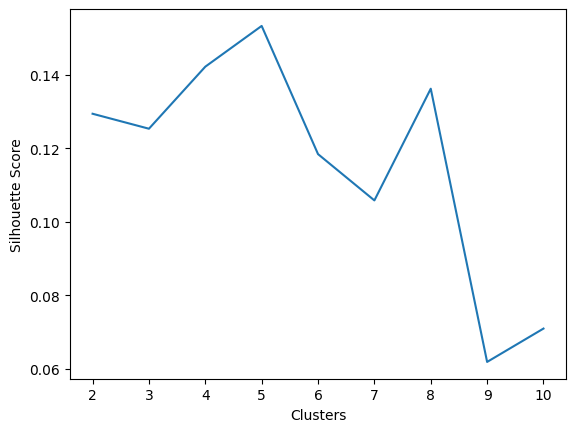

In [98]:
# Select number of clusters using "elbow" heuristic
# Evaluate using sklearn's shillouette score metric / higher is better
score = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X)
    score.append(silhouette_score(X, kmeans.labels_))

plt.plot(range(2, 11), score)
plt.xlabel("Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2, 11))
plt.show()

In [99]:
# Plot clusters on a world map for visualization purposes

## Association Mining

## Latent Variable Modeling